In [3]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns



In [4]:
H, W = 224, 224
BATCH_SIZE = 32
EPOCH = 50

In [5]:
image_paths = []
image_labels = []
normal_count = scc_count = 0

for dirname, _, filenames in os.walk('/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/'):
    for filename in filenames:
        if "bak" in filename: continue    #Ignore all images ending with .bak
        path = os.path.join(dirname, filename)
        image_paths.append(path)
        if 'normal' in filename:
            image_labels.append(0)
            normal_count += 1
        else:
            image_labels.append(1)
            scc_count += 1

#Shuffle
combined = list(zip(image_paths, image_labels))
random.shuffle(combined)
image_paths, image_labels = zip(*combined)
image_paths = list(image_paths)
image_labels = list(image_labels)

print(image_paths[:5], '\n')
print(image_labels[:5], '\n')
print("Image count:", len(image_paths))
print("Normal count:", normal_count)
print("SCC count:", scc_count)
print("Image size:", Image.open(image_paths[0]).size)
print("Image mode:", Image.open(image_paths[0]).mode)

['/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_normal/oral_normal_0944.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_normal/oral_normal_1461.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_2263.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_1402.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_1385.jpg'] 

[0, 0, 1, 1, 1] 

Image count: 10000
Normal count: 5000
SCC count: 5000
Image size: (512, 512)
Image mode: RGB


In [6]:
#train, val, test = 70%, 15%, 15%
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, image_labels, test_size=0.3, stratify=image_labels)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels)

print("Training size:", len(train_paths))
print("Validation size:", len(val_paths))
print("Testing size:", len(test_paths))

Training size: 7000
Validation size: 1500
Testing size: 1500


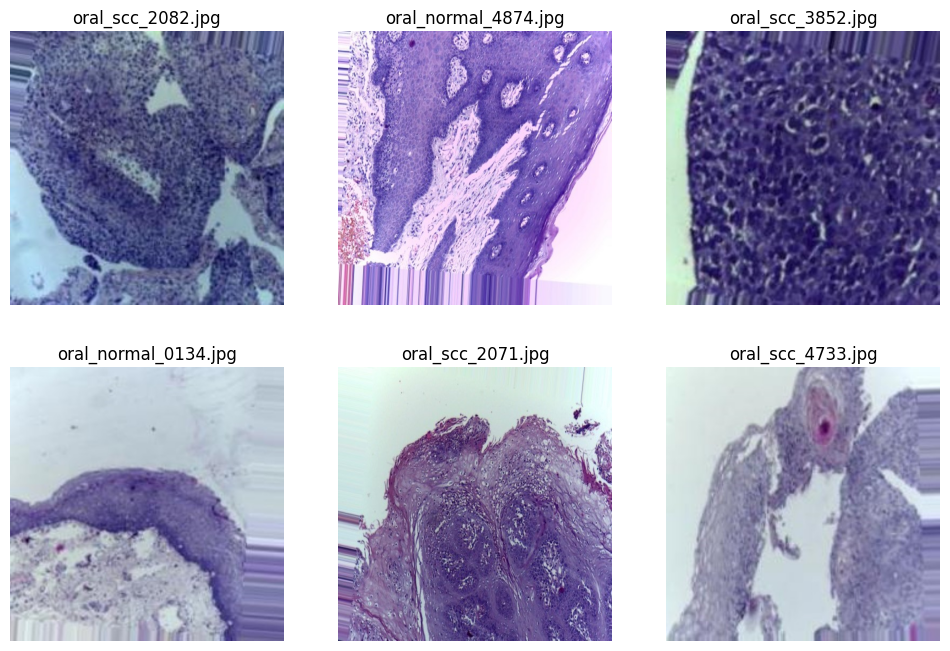

In [7]:
sample_images = random.sample(train_paths, 6)
plt.figure(figsize=(12, 8))

for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=12)
    plt.axis('off')

plt.show()

In [8]:
# Calculate Mean and Standard Deviation of the training set
transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor()
])

mean = 0.
std = 0.
n = 0

for path in tqdm(train_paths):
    img = Image.open(path).convert('RGB')
    img = transform(img)  # shape: [3, H, W]
    mean += img.mean(dim=[1,2])
    std += img.std(dim=[1,2])
    n += 1

mean /= n
std /= n

print("Mean:", mean)
print("Std:", std)

100%|██████████| 7000/7000 [01:30<00:00, 77.17it/s]

Mean: tensor([0.5531, 0.5154, 0.7294])
Std: tensor([0.1618, 0.1926, 0.1223])


In [9]:
#Data augmentation 
train_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

val_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

test_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

In [10]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, image_labels, transform=None):
        self.image_paths = image_paths
        self.labels = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# For train_loader, val_loader and test_loader
# There are approximately len({}_paths) / BATCH_SIZE batches in total
# Each batch has a shape of [BATCH_SIZE, 3, H, W]
train_dataset = ImageDataset(train_paths, train_labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 

val_dataset = ImageDataset(val_paths, val_labels, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True) 

test_dataset = ImageDataset(test_paths, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

In [12]:

EPOCH = 25                 # 第一階段的 Epoch 數量

best_model_path = "best_oral_cancer_model.pth"

# 設置 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


print("Loading ResNet50 model...")
model = models.resnet50(pretrained=True)

# 凍結所有層
for param in model.parameters():
    param.requires_grad = False

# 最後的分類層
num_features = model.fc.in_features 
model.fc = nn.Linear(num_features, 2) # (normal, scc)

model = model.to(device)

# --- Training ---
print("\n--- Training  ---")

criterion = nn.CrossEntropyLoss()

# 優化器 
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0

for epoch in range(EPOCH):
    model.train() 
    train_loss = 0.0
    train_corrects = 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCH} [Phase 1 Train]")
    
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        train_pbar.set_postfix({'loss': loss.item()})

    epoch_train_loss = train_loss / len(train_dataset)
    epoch_train_acc = train_corrects.double() / len(train_dataset)

    model.eval() 
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCH} [Phase 1 Val]")
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            val_pbar.set_postfix({'loss': loss.item()})

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_corrects.double() / len(val_dataset)

    # 🔥 [新增] 將數據存入 history (.item() 將 tensor 轉為數值)
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc.item())
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc.item())

    print(f"Phase 1 Epoch {epoch+1}/{EPOCH} | Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")
    
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved to {best_model_path} with Val Acc: {best_val_acc:.4f}")
        
print("finished.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
Loading ResNet50 model...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 243MB/s]



--- Training  ---


Epoch 1/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:20<00:00,  2.35it/s, loss=0.547]


Phase 1 Epoch 1/25 | Train Loss: 0.5301 Acc: 0.7329 | Val Loss: 0.5097 Acc: 0.7460
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.7460


Epoch 2/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.91it/s, loss=0.47] 


Phase 1 Epoch 2/25 | Train Loss: 0.4559 Acc: 0.7831 | Val Loss: 0.4414 Acc: 0.7873
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.7873


Epoch 3/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.91it/s, loss=0.313]


Phase 1 Epoch 3/25 | Train Loss: 0.4494 Acc: 0.7906 | Val Loss: 0.4230 Acc: 0.8080
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8080


Epoch 4/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.83it/s, loss=0.48] 


Phase 1 Epoch 4/25 | Train Loss: 0.4291 Acc: 0.7994 | Val Loss: 0.4177 Acc: 0.8100
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8100


Epoch 5/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.91it/s, loss=0.434]


Phase 1 Epoch 5/25 | Train Loss: 0.4158 Acc: 0.8074 | Val Loss: 0.4134 Acc: 0.8080


Epoch 6/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.94it/s, loss=0.669]


Phase 1 Epoch 6/25 | Train Loss: 0.4256 Acc: 0.8037 | Val Loss: 0.4674 Acc: 0.7907


Epoch 7/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.78it/s, loss=0.379]


Phase 1 Epoch 7/25 | Train Loss: 0.4038 Acc: 0.8146 | Val Loss: 0.4123 Acc: 0.8180
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8180


Epoch 8/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.79it/s, loss=0.203]


Phase 1 Epoch 8/25 | Train Loss: 0.4073 Acc: 0.8103 | Val Loss: 0.4108 Acc: 0.8200
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8200


Epoch 9/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.87it/s, loss=0.588]


Phase 1 Epoch 9/25 | Train Loss: 0.3885 Acc: 0.8293 | Val Loss: 0.3814 Acc: 0.8260
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8260


Epoch 10/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.84it/s, loss=0.304]


Phase 1 Epoch 10/25 | Train Loss: 0.3877 Acc: 0.8230 | Val Loss: 0.3780 Acc: 0.8320
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8320


Epoch 11/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.99it/s, loss=0.352]


Phase 1 Epoch 11/25 | Train Loss: 0.3756 Acc: 0.8296 | Val Loss: 0.3973 Acc: 0.8153


Epoch 12/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.82it/s, loss=0.534]


Phase 1 Epoch 12/25 | Train Loss: 0.3958 Acc: 0.8200 | Val Loss: 0.3635 Acc: 0.8440
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8440


Epoch 13/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.89it/s, loss=0.387]


Phase 1 Epoch 13/25 | Train Loss: 0.3787 Acc: 0.8306 | Val Loss: 0.4049 Acc: 0.8127


Epoch 14/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.92it/s, loss=0.44] 


Phase 1 Epoch 14/25 | Train Loss: 0.3842 Acc: 0.8273 | Val Loss: 0.3853 Acc: 0.8227


Epoch 15/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.84it/s, loss=0.39] 


Phase 1 Epoch 15/25 | Train Loss: 0.3936 Acc: 0.8206 | Val Loss: 0.4320 Acc: 0.7940


Epoch 16/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.92it/s, loss=0.145]


Phase 1 Epoch 16/25 | Train Loss: 0.3636 Acc: 0.8394 | Val Loss: 0.3680 Acc: 0.8373


Epoch 17/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.85it/s, loss=0.482]


Phase 1 Epoch 17/25 | Train Loss: 0.3849 Acc: 0.8269 | Val Loss: 0.3632 Acc: 0.8407


Epoch 18/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.95it/s, loss=0.318]


Phase 1 Epoch 18/25 | Train Loss: 0.3754 Acc: 0.8331 | Val Loss: 0.3705 Acc: 0.8340


Epoch 19/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.95it/s, loss=0.651]


Phase 1 Epoch 19/25 | Train Loss: 0.3769 Acc: 0.8297 | Val Loss: 0.5826 Acc: 0.7340


Epoch 20/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.94it/s, loss=0.249]


Phase 1 Epoch 20/25 | Train Loss: 0.3680 Acc: 0.8363 | Val Loss: 0.3622 Acc: 0.8320


Epoch 21/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.84it/s, loss=0.318]


Phase 1 Epoch 21/25 | Train Loss: 0.3766 Acc: 0.8284 | Val Loss: 0.3389 Acc: 0.8567
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8567


Epoch 22/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.96it/s, loss=0.345]


Phase 1 Epoch 22/25 | Train Loss: 0.3668 Acc: 0.8364 | Val Loss: 0.3622 Acc: 0.8367


Epoch 23/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.95it/s, loss=0.354]


Phase 1 Epoch 23/25 | Train Loss: 0.3800 Acc: 0.8281 | Val Loss: 0.3622 Acc: 0.8340


Epoch 24/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.90it/s, loss=0.395]


Phase 1 Epoch 24/25 | Train Loss: 0.3646 Acc: 0.8383 | Val Loss: 0.3574 Acc: 0.8400


Epoch 25/25 [Phase 1 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.91it/s, loss=0.324]

Phase 1 Epoch 25/25 | Train Loss: 0.3632 Acc: 0.8359 | Val Loss: 0.3301 Acc: 0.8660
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8660
finished.


In [13]:
# 模型微調 
print("\n--- Fine-Tuning ---")

NUM_FINETUNE_EPOCHS = 20   # 第二階段的 Epoch 數量

# 載入第一階段的最佳模型
model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from Phase 1 with Val Acc: {best_val_acc:.4f}")

# 解凍所有層
for param in model.parameters():
    param.requires_grad = True

# 優化器
optimizer = optim.Adam(model.parameters(), lr=1e-5) # 學習率 0.00001

best_finetune_acc = best_val_acc 

for epoch in range(NUM_FINETUNE_EPOCHS):
    model.train()
    train_loss = 0.0
    train_corrects = 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_FINETUNE_EPOCHS} [Phase 2 Train]")
    
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        train_pbar.set_postfix({'loss': loss.item()})

    epoch_train_loss = train_loss / len(train_dataset)
    epoch_train_acc = train_corrects.double() / len(train_dataset)

    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_FINETUNE_EPOCHS} [Phase 2 Val]")
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            val_pbar.set_postfix({'loss': loss.item()})

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_corrects.double() / len(val_dataset)

    # 🔥 [新增] 繼續將數據存入同一個 history (接續 Phase 1)
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc.item())
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc.item())

    print(f"Phase 2 Epoch {epoch+1}/{NUM_FINETUNE_EPOCHS} | Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")
    
    if epoch_val_acc > best_finetune_acc:
        best_finetune_acc = epoch_val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New BEST model saved (Fine-Tuning) to {best_model_path} with Val Acc: {best_finetune_acc:.4f}")

print(" Fine-tuning finished.")




--- Fine-Tuning ---
Loaded best model from Phase 1 with Val Acc: 0.8660


Epoch 1/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.97it/s, loss=0.162] 


Phase 2 Epoch 1/20 | Train Loss: 0.2666 Acc: 0.8891 | Val Loss: 0.2143 Acc: 0.9040
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9040


Epoch 2/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.94it/s, loss=0.0818]


Phase 2 Epoch 2/20 | Train Loss: 0.1767 Acc: 0.9327 | Val Loss: 0.1570 Acc: 0.9333
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9333


Epoch 3/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.94it/s, loss=0.331] 


Phase 2 Epoch 3/20 | Train Loss: 0.1263 Acc: 0.9513 | Val Loss: 0.1221 Acc: 0.9493
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9493


Epoch 4/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.95it/s, loss=0.0114] 


Phase 2 Epoch 4/20 | Train Loss: 0.1042 Acc: 0.9600 | Val Loss: 0.0853 Acc: 0.9693
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9693


Epoch 5/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.94it/s, loss=0.0101] 


Phase 2 Epoch 5/20 | Train Loss: 0.0797 Acc: 0.9713 | Val Loss: 0.0731 Acc: 0.9727
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9727


Epoch 6/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.98it/s, loss=0.096]  


Phase 2 Epoch 6/20 | Train Loss: 0.0628 Acc: 0.9767 | Val Loss: 0.0637 Acc: 0.9760
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9760


Epoch 7/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.96it/s, loss=0.0215] 


Phase 2 Epoch 7/20 | Train Loss: 0.0576 Acc: 0.9793 | Val Loss: 0.0551 Acc: 0.9820
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9820


Epoch 8/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.94it/s, loss=0.0594] 


Phase 2 Epoch 8/20 | Train Loss: 0.0508 Acc: 0.9799 | Val Loss: 0.0542 Acc: 0.9800


Epoch 9/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.02it/s, loss=0.0102] 


Phase 2 Epoch 9/20 | Train Loss: 0.0436 Acc: 0.9840 | Val Loss: 0.0474 Acc: 0.9813


Epoch 10/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.01it/s, loss=0.0267]  


Phase 2 Epoch 10/20 | Train Loss: 0.0434 Acc: 0.9836 | Val Loss: 0.0529 Acc: 0.9773


Epoch 11/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.92it/s, loss=0.0153] 


Phase 2 Epoch 11/20 | Train Loss: 0.0441 Acc: 0.9827 | Val Loss: 0.0410 Acc: 0.9867
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9867


Epoch 12/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.98it/s, loss=0.00923] 


Phase 2 Epoch 12/20 | Train Loss: 0.0375 Acc: 0.9866 | Val Loss: 0.0461 Acc: 0.9853


Epoch 13/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.00it/s, loss=0.0786]  


Phase 2 Epoch 13/20 | Train Loss: 0.0311 Acc: 0.9860 | Val Loss: 0.0396 Acc: 0.9833


Epoch 14/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.00it/s, loss=0.0155]  


Phase 2 Epoch 14/20 | Train Loss: 0.0365 Acc: 0.9873 | Val Loss: 0.0418 Acc: 0.9840


Epoch 15/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.93it/s, loss=0.14]    


Phase 2 Epoch 15/20 | Train Loss: 0.0366 Acc: 0.9850 | Val Loss: 0.0351 Acc: 0.9880
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9880


Epoch 16/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:12<00:00,  3.91it/s, loss=0.02]    


Phase 2 Epoch 16/20 | Train Loss: 0.0293 Acc: 0.9889 | Val Loss: 0.0389 Acc: 0.9887
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9887


Epoch 17/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  3.97it/s, loss=0.0153]  


Phase 2 Epoch 17/20 | Train Loss: 0.0267 Acc: 0.9890 | Val Loss: 0.0405 Acc: 0.9867


Epoch 18/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.05it/s, loss=0.0247]  


Phase 2 Epoch 18/20 | Train Loss: 0.0257 Acc: 0.9890 | Val Loss: 0.0619 Acc: 0.9813


Epoch 19/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.01it/s, loss=0.000306]


Phase 2 Epoch 19/20 | Train Loss: 0.0270 Acc: 0.9891 | Val Loss: 0.0376 Acc: 0.9840


Epoch 20/20 [Phase 2 Val]: 100%|██████████| 47/47 [00:11<00:00,  4.03it/s, loss=0.0127]  

Phase 2 Epoch 20/20 | Train Loss: 0.0242 Acc: 0.9904 | Val Loss: 0.0402 Acc: 0.9833
 Fine-tuning finished.


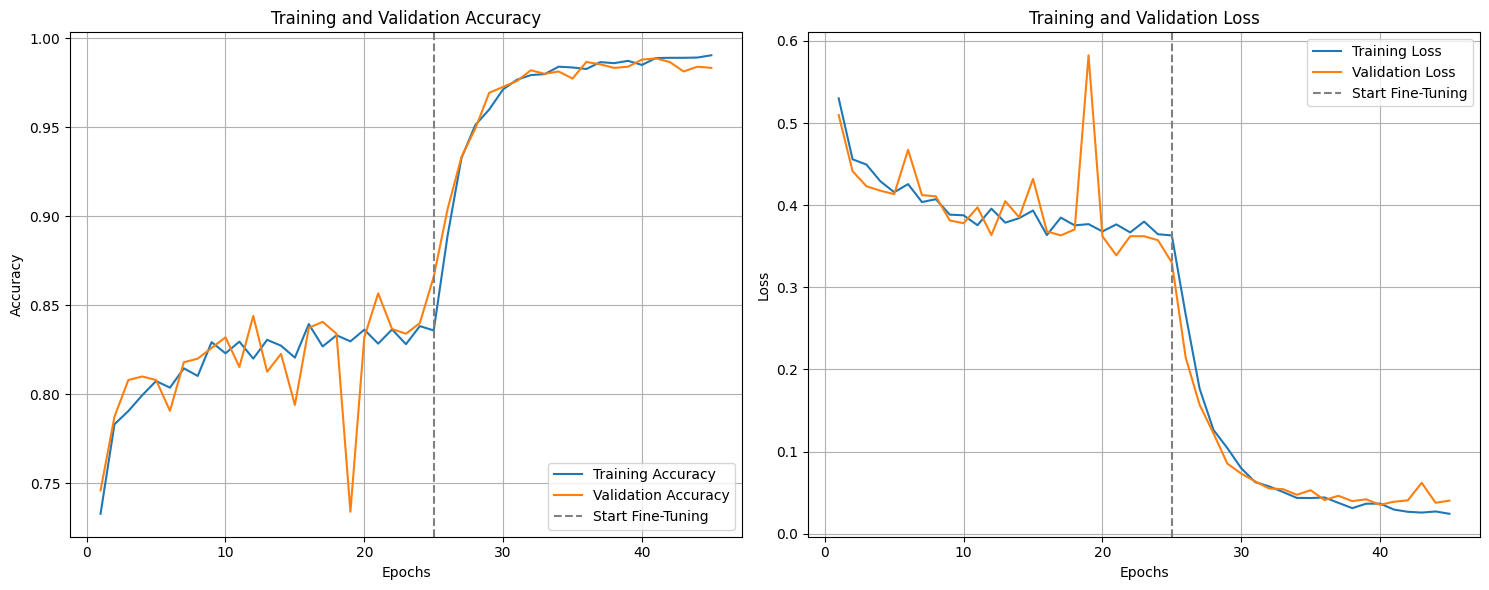

In [14]:
# ---  Learning Curve ---
def plot_learning_curves(history, phase1_epochs):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    
    plt.axvline(x=phase1_epochs, color='gray', linestyle='--', label='Start Fine-Tuning')
    
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    

    plt.axvline(x=phase1_epochs, color='gray', linestyle='--', label='Start Fine-Tuning')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


plot_learning_curves(history, phase1_epochs=EPOCH)

In [19]:
from torch.utils.data import ConcatDataset, DataLoader

full_train_dataset = ConcatDataset([train_dataset, val_dataset])

full_train_loader = DataLoader(full_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


model.load_state_dict(torch.load(best_model_path))

history_phase3 = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [], 
    'val_acc': []
}

REFINE_EPOCHS = 20 
optimizer = optim.Adam(model.parameters(), lr=1e-5) 
criterion = nn.CrossEntropyLoss()



for epoch in range(REFINE_EPOCHS):
    model.train()
    train_loss = 0.0
    train_corrects = 0
    
    pbar = tqdm(full_train_loader, desc=f"Epoch {epoch+1}/{REFINE_EPOCHS} [Train]")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        
        pbar.set_postfix({'loss': loss.item()})
        
    epoch_train_loss = train_loss / len(full_train_dataset)
    epoch_train_acc = (train_corrects.double() / len(full_train_dataset)).item()


    model.eval()
    val_loss = 0.0
    val_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            
    epoch_val_loss = val_loss / len(test_dataset)
    epoch_val_acc = (val_corrects.double() / len(test_dataset)).item()

    # --- 紀錄數據 ---
    history_phase3['train_loss'].append(epoch_train_loss)
    history_phase3['train_acc'].append(epoch_train_acc)
    history_phase3['val_loss'].append(epoch_val_loss)
    history_phase3['val_acc'].append(epoch_val_acc)

    print(f"   Train Acc: {epoch_train_acc:.4f} | Test Acc: {epoch_val_acc:.4f}")

# 儲存最終模型
final_model_path = "final_refined_model.pth"
torch.save(model.state_dict(), final_model_path)

Epoch 1/20 [Train]: 100%|██████████| 266/266 [01:38<00:00,  2.71it/s, loss=0.021]   


   Train Acc: 0.9878 | Test Acc: 0.9867


Epoch 2/20 [Train]: 100%|██████████| 266/266 [01:39<00:00,  2.66it/s, loss=0.0147]  


   Train Acc: 0.9894 | Test Acc: 0.9860


Epoch 3/20 [Train]: 100%|██████████| 266/266 [01:39<00:00,  2.68it/s, loss=0.0176]  


   Train Acc: 0.9931 | Test Acc: 0.9860


Epoch 4/20 [Train]: 100%|██████████| 266/266 [01:39<00:00,  2.68it/s, loss=0.00109] 


   Train Acc: 0.9926 | Test Acc: 0.9867


Epoch 5/20 [Train]: 100%|██████████| 266/266 [01:39<00:00,  2.68it/s, loss=0.0195]  


   Train Acc: 0.9914 | Test Acc: 0.9900


Epoch 6/20 [Train]: 100%|██████████| 266/266 [01:39<00:00,  2.67it/s, loss=0.000707]


   Train Acc: 0.9926 | Test Acc: 0.9853


Epoch 7/20 [Train]: 100%|██████████| 266/266 [01:39<00:00,  2.68it/s, loss=0.0108]  


   Train Acc: 0.9925 | Test Acc: 0.9880


Epoch 8/20 [Train]: 100%|██████████| 266/266 [01:39<00:00,  2.67it/s, loss=0.00398] 


   Train Acc: 0.9921 | Test Acc: 0.9880


Epoch 9/20 [Train]: 100%|██████████| 266/266 [01:39<00:00,  2.68it/s, loss=0.00235] 


   Train Acc: 0.9914 | Test Acc: 0.9893


Epoch 10/20 [Train]: 100%|██████████| 266/266 [01:39<00:00,  2.68it/s, loss=0.00519] 


   Train Acc: 0.9926 | Test Acc: 0.9873


Epoch 11/20 [Train]: 100%|██████████| 266/266 [01:39<00:00,  2.68it/s, loss=0.113]   


   Train Acc: 0.9946 | Test Acc: 0.9860


Epoch 12/20 [Train]: 100%|██████████| 266/266 [01:39<00:00,  2.67it/s, loss=0.116]   


   Train Acc: 0.9929 | Test Acc: 0.9900


Epoch 13/20 [Train]: 100%|██████████| 266/266 [01:39<00:00,  2.68it/s, loss=0.00127] 


   Train Acc: 0.9952 | Test Acc: 0.9887


Epoch 14/20 [Train]: 100%|██████████| 266/266 [01:39<00:00,  2.68it/s, loss=0.000627]


   Train Acc: 0.9939 | Test Acc: 0.9880


Epoch 15/20 [Train]: 100%|██████████| 266/266 [01:39<00:00,  2.68it/s, loss=0.0115]  


   Train Acc: 0.9945 | Test Acc: 0.9900


Epoch 16/20 [Train]: 100%|██████████| 266/266 [01:39<00:00,  2.68it/s, loss=0.00489] 


   Train Acc: 0.9958 | Test Acc: 0.9860


Epoch 17/20 [Train]: 100%|██████████| 266/266 [01:39<00:00,  2.68it/s, loss=4.61e-5] 


   Train Acc: 0.9940 | Test Acc: 0.9873


Epoch 18/20 [Train]: 100%|██████████| 266/266 [01:39<00:00,  2.68it/s, loss=0.000309]


   Train Acc: 0.9946 | Test Acc: 0.9867


Epoch 19/20 [Train]: 100%|██████████| 266/266 [01:39<00:00,  2.68it/s, loss=0.000162]


   Train Acc: 0.9954 | Test Acc: 0.9913


Epoch 20/20 [Train]: 100%|██████████| 266/266 [01:39<00:00,  2.68it/s, loss=0.000692]


   Train Acc: 0.9959 | Test Acc: 0.9887


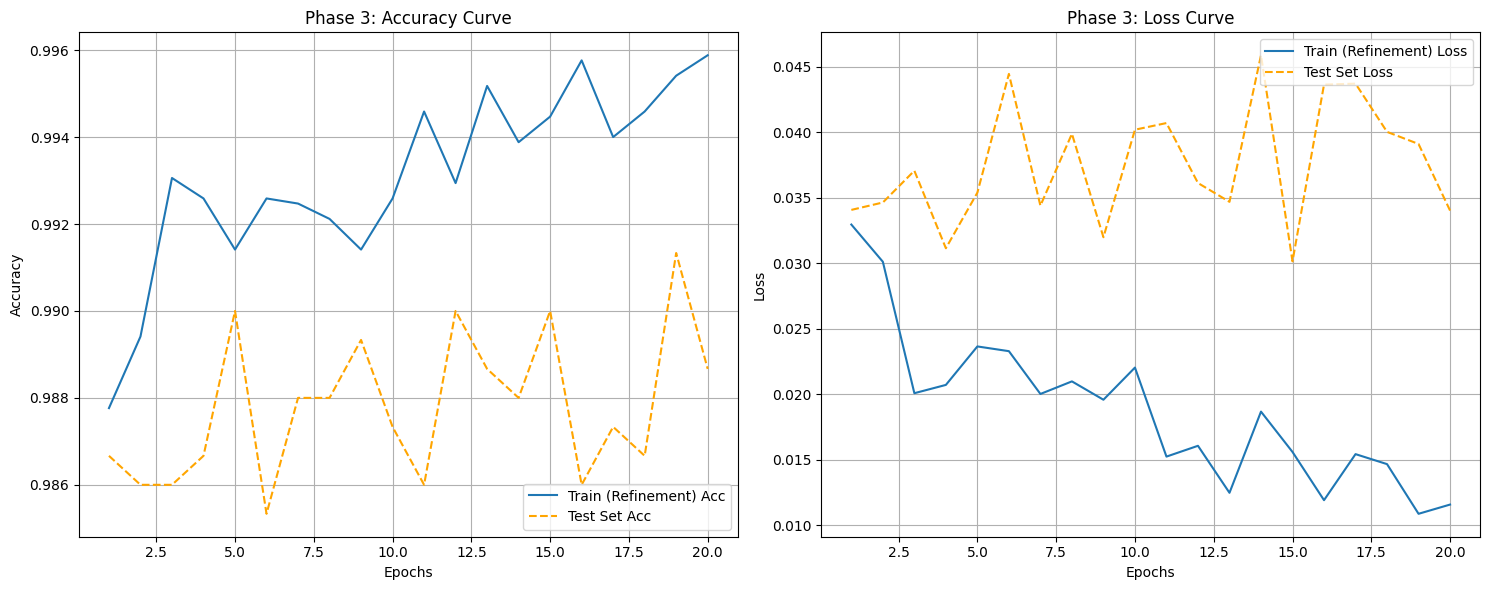

In [20]:
def plot_phase3_curves(history):
    acc = history['train_acc']
    val_acc = history['val_acc'] 
    loss = history['train_loss']
    val_loss = history['val_loss'] 
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 6))

    # Accuracy Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train (Refinement) Acc')
    plt.plot(epochs_range, val_acc, label='Test Set Acc', color='orange', linestyle='--')
    plt.title('Phase 3: Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Loss Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train (Refinement) Loss')
    plt.plot(epochs_range, val_loss, label='Test Set Loss', color='orange', linestyle='--')
    plt.title('Phase 3: Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 執行畫圖
plot_phase3_curves(history_phase3)


--- Final Testing & Metrics Calculation ---


Testing: 100%|██████████| 47/47 [00:11<00:00,  4.01it/s]


 Final Results
Accuracy  : 0.9887
Precision : 0.9919
Recall    : 0.9853
F1 Score  : 0.9886
------------------------------

 Report 
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       750
         SCC       0.99      0.99      0.99       750

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



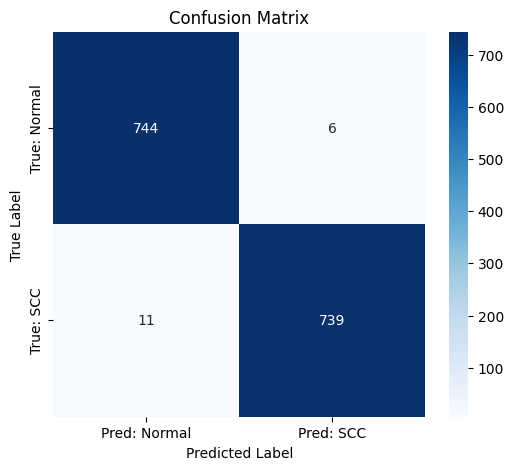

In [21]:
print("\n--- Final Testing & Metrics Calculation ---")

model.load_state_dict(torch.load(final_model_path))

model.eval()
model.to(device)


all_labels = []
all_preds = []


with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())


accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')

print("\n" + "="*30)
print(f" Final Results")
print("="*30)
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print("-" * 30)


print("\n Report ")
print(classification_report(all_labels, all_preds, target_names=['Normal', 'SCC']))


cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred: Normal', 'Pred: SCC'],
            yticklabels=['True: Normal', 'True: SCC'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()